In [7]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import re
import os
import statsmodels.api as sm
import sys

sys.path.append("/home/gy/nandu/nandu-research/GongYun/Util")
from gxUtil import *
from gxConfig import *

In [8]:
instrument = "sc"
tradeInstrument = instrument.upper()+"0001"
priceTick = d_priceTick[instrument]
multiplier = d_multiplier[instrument]
sim_result_dir = "/mnt/users/gy/simulation_result/"+tradeInstrument+"/"
l_strategy = [
    "kronos_base_speedPenalty",
            ]
l_param = ['fracCut','G_Factor1']
d_strategyDate = {}
for strategy in l_strategy:
    l_thisStrategyDate=[]
    for dirpath,dirnames,filenames in os.walk(sim_result_dir+strategy):
        for filename in filenames:
            if "table" in filename:
                date = (re.findall(r'\d+',filename))[0]
                l_thisStrategyDate.append(date)
    d_strategyDate[strategy] = l_thisStrategyDate
l_date = ["initial"]
for key in d_strategyDate.keys():
    if l_date == ["initial"]:
        l_date = d_strategyDate[key]
    else:
        l_date = [date for date in l_date if date in d_strategyDate[key]]
l_date.sort()    

In [9]:
startDate = "20201101"
endDate="20201207"
l_date_2 = []
for date in l_date:
    if (date>=startDate) & (date<=endDate):
        l_date_2.append(date)
l_date = l_date_2
l_date.sort()

In [10]:
df_answer = pd.DataFrame()
df_table = pd.DataFrame()
df_parameter = pd.DataFrame()
for date in l_date:
    df_table_day = pd.read_csv(sim_result_dir+strategy+"/"+date+"/"+instrument+"_table_"+date+".csv")
    df_table_day["origIndex"] = df_table_day.index
    df_table_day["mktDate"] = date
    df_table = df_table.append(df_table_day[df_table_day["origIndex"]%2==0])
    
    df_parameter_day = pd.read_csv(sim_result_dir+strategy+"/"+date+"/"+instrument+"_parameter_"+date+".csv").T
    df_parameter_day.columns = df_parameter_day.loc["Unnamed: 0"]
    df_parameter_day.drop(["Unnamed: 0"],inplace = True)
    df_parameter_day["origIndex"] = df_parameter_day.index
    df_parameter_day["mktDate"] = date
    
    df_parameter_day["origIndex"] = pd.to_numeric(df_parameter_day["origIndex"])
    df_parameter_day["signalScoreB"] = pd.to_numeric(df_parameter_day["signalScoreB"])
    
    # terminals in different senarios
    df_parameter_day["terminal"] = pd.to_numeric(df_parameter_day["terminal"])
       
    df_parameter_day["allSuccessTerminal"] = pd.to_numeric(df_parameter_day["allSuccessTerminal"])
    df_parameter_day["cumsumAllSuccessPNL"]=df_parameter_day["allSuccessTerminal"].cumsum() 
    df_parameter_day["cancelFailedTerminal"] = pd.to_numeric(df_parameter_day["cancelFailedTerminal"])
    df_parameter_day["cumsumCancelFailedPNL"]=df_parameter_day["cancelFailedTerminal"].cumsum()     
    df_parameter_day["joinFailedTerminal"] = pd.to_numeric(df_parameter_day["joinFailedTerminal"])
    df_parameter_day["cumsumJoinFailedPNL"]=df_parameter_day["joinFailedTerminal"].cumsum()     
    df_parameter_day["takingFailedTerminal"] = pd.to_numeric(df_parameter_day["takingFailedTerminal"])
    df_parameter_day["cumsumTakeFailedPNL"]=df_parameter_day["takingFailedTerminal"].cumsum()      
    df_parameter_day["improvingFailedTerminal"] = pd.to_numeric(df_parameter_day["improvingFailedTerminal"])
    df_parameter_day["cumsumImproveFailedPNL"]=df_parameter_day["improvingFailedTerminal"].cumsum()   
    df_parameter_day["allFailedTerminal"] = pd.to_numeric(df_parameter_day["allFailedTerminal"])
    df_parameter_day["cumsumAllFailedPNL"]=df_parameter_day["allFailedTerminal"].cumsum()   
    # cancel number
    df_parameter_day["allSuccessCancelNum"] = pd.to_numeric(df_parameter_day["allSuccessCancelNum"])

    # tradeVolume in different senarios
    df_parameter_day["allSuccessTradeNum"] = pd.to_numeric(df_parameter_day["allSuccessTradeNum"])
    df_parameter_day["cancelFailedTradeNum"] = pd.to_numeric(df_parameter_day["cancelFailedTradeNum"])
    df_parameter_day["takingFailedTradeNum"] = pd.to_numeric(df_parameter_day["takingFailedTradeNum"])
    df_parameter_day["improvingFailedTradeNum"] = pd.to_numeric(df_parameter_day["improvingFailedTradeNum"])
    df_parameter_day["joinFailedTradeNum"] = pd.to_numeric(df_parameter_day["joinFailedTradeNum"])
    df_parameter_day["allFailedTradeNum"] = pd.to_numeric(df_parameter_day["allFailedTradeNum"]) 
    
    df_parameter_day["allSuccessCancelNum"] = pd.to_numeric(df_parameter_day["allSuccessCancelNum"])
    
    df_parameter_day["cumsumAllSuccessTradeVolume"]=df_parameter_day["allSuccessTradeNum"].cumsum()
    df_parameter_day["cumsumCancelFailedTradeVolume"]=df_parameter_day["cancelFailedTradeNum"].cumsum()
    df_parameter_day["cumsumTakeFailedTradeVolume"]=df_parameter_day["takingFailedTradeNum"].cumsum()
    df_parameter_day["cumsumImproveFailedTradeVolume"]=df_parameter_day["improvingFailedTradeNum"].cumsum()
    df_parameter_day["cumsumJoinFailedTradeVolume"]=df_parameter_day["joinFailedTradeNum"].cumsum()
    df_parameter_day["cumsumAllFailedTradeVolume"]=df_parameter_day["allFailedTradeNum"].cumsum()
    
    df_parameter_day["cumsumAllSuccessCancelVolume"]=df_parameter_day["allSuccessCancelNum"].cumsum()
    
    
    
    df_parameter = df_parameter.append(df_parameter_day)#[df_parameter_day["origIndex"]%2==0])


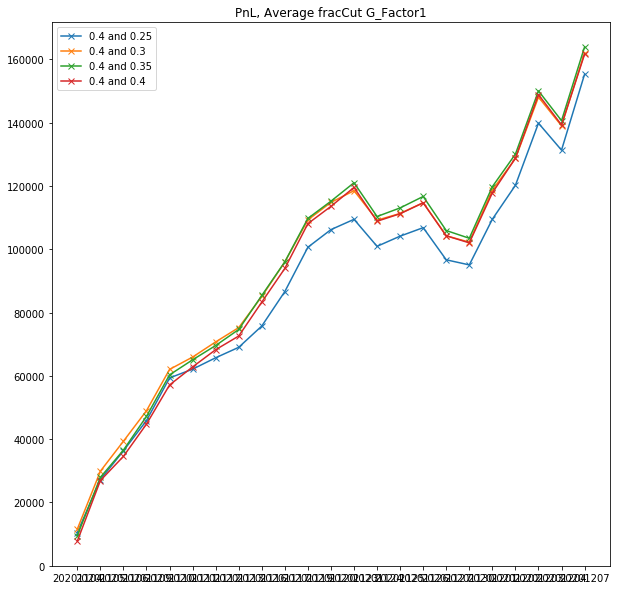

In [11]:
plt.figure(figsize=(10,10))
plt.title("PnL, Average "+l_param[0]+" "+l_param[1])
l_value0 = df_parameter[l_param[0]].unique()
l_value1 = df_parameter[l_param[1]].unique()
#l_value0=["0.0","0.004"]
for i in l_value0:
    for j in l_value1:
        df = df_parameter.loc[(df_parameter[l_param[0]]==i)&(df_parameter[l_param[1]]==j),["mktDate","terminal"]].copy()
        df["cumsumPNL"] =  df["terminal"].cumsum()
        plt.plot(df.mktDate,df.cumsumPNL*multiplier,marker='x',label=str(i)+" and "+str(j))
plt.legend(loc="upper left")
plt.show()    

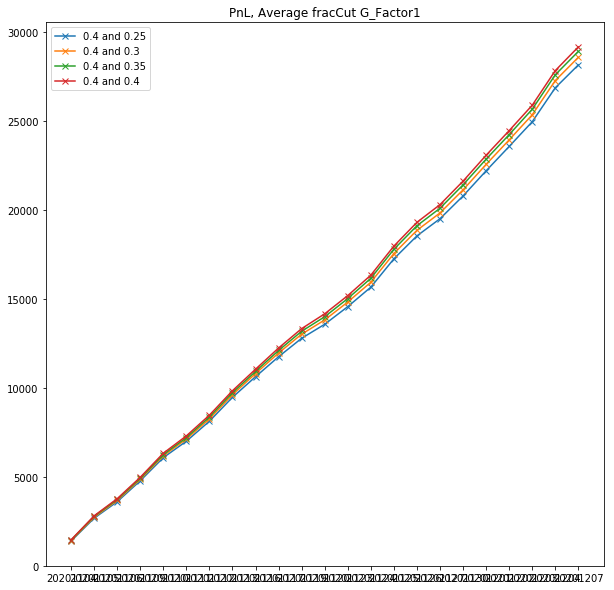

In [12]:
plt.figure(figsize=(10,10))
plt.title("PnL, Average "+l_param[0]+" "+l_param[1])
l_value0 = df_parameter[l_param[0]].unique()
l_value1 = df_parameter[l_param[1]].unique()
#l_value0=["0.0","0.004"]
for i in l_value0:
    for j in l_value1:
        df = df_parameter.loc[(df_parameter[l_param[0]]==i)&(df_parameter[l_param[1]]==j),["mktDate","allSuccessTradeNum"]].copy()
        df["cumsumAllSuccessTradeNum"] =  df["allSuccessTradeNum"].cumsum()
        plt.plot(df.mktDate,df.cumsumAllSuccessTradeNum,marker='x',label=str(i)+" and "+str(j))
plt.legend(loc="upper left")
plt.show()    

In [13]:
df_answer = pd.DataFrame()
l_value0 = df_parameter[l_param[0]].unique()
l_value1 = df_parameter[l_param[1]].unique()
for i in l_value0:
    for j in l_value1:
        df = df_parameter.loc[(df_parameter[l_param[0]]==i)&(df_parameter[l_param[1]]==j)].copy()
        l_data = []
        l_data.append(i)
        l_data.append(j)
        l_data.append(df.terminal.sum()*multiplier)
        l_data.append(df.allSuccessTerminal.sum()/df.allSuccessTradeNum.sum()*multiplier)
        l_data.append(df.cancelFailedTerminal.sum()/df.cancelFailedTradeNum.sum()*multiplier)
        l_data.append(df.joinFailedTerminal.sum()/df.joinFailedTradeNum.sum()*multiplier)
        l_data.append(df.improvingFailedTerminal.sum()/df.improvingFailedTradeNum.sum()*multiplier)
        l_data.append(df.takingFailedTerminal.sum()/df.takingFailedTradeNum.sum()*multiplier)
        l_data.append(df.allFailedTerminal.sum()/df.allFailedTradeNum.sum()*multiplier)
        l_data.append(df.allSuccessTradeNum.sum())

        df_answer_tmp = pd.DataFrame(l_data)
        df_answer = df_answer.append(df_answer_tmp.T)
df_answer.columns=[l_param[0],l_param[1],"TotalTerminal","AllS","CancelF","JoinF","ImproveF","TakeF","AllF","TotalTradingVolume",]

In [14]:
df_answer.sort_values(by="TotalTerminal",ascending=False)

,fracCut,G_Factor1,TotalTerminal,AllS,CancelF,JoinF,ImproveF,TakeF,AllF,TotalTradingVolume
0,0.4,0.35,163962,11.5002,8.27327,0.725851,10.2349,9.08514,-9.02477,28910
0,0.4,0.3,162081,11.5532,8.27579,0.638368,10.2536,9.13195,-9.0539,28578
0,0.4,0.4,161651,11.3979,8.16259,0.783493,10.1553,9.02002,-8.87824,29164
0,0.4,0.25,155341,11.7343,8.12617,1.19979,10.4351,9.26303,-9.26577,28152


In [ ]:
df_answer["G_Factor1"] = df_answer["G_Factor1"].apply(lambda x: float(x))
df_answer["signalScoreB"] = df_answer["signalScoreB"].apply(lambda x: float(x))

In [ ]:
df_answer.loc[(df_answer["TotalTerminal"]==df_answer["TotalTerminal"].max())]

In [ ]:
df_answer.loc[(df_answer["G_Factor1"]==0.0)&(df_answer["signalScoreB"]==0.0)]

In [ ]:
plt.figure(figsize=(10,10))
plt.title("PnL, Average "+l_param[0]+" "+l_param[1])
l_value0 = df_parameter[l_param[0]].unique()
l_value1 = df_parameter[l_param[1]].unique()
for i in l_value0:
    for j in l_value1:
        df = df_parameter.loc[(df_parameter[l_param[0]]==i)&(df_parameter[l_param[1]]==j),["mktDate","terminal"]].copy()
        df["cumsumPNL"] =  df["allFailedTerminal"].cumsum()
        plt.plot(df.mktDate,df.cumsumPNL*multiplier,marker='x',label=str(i)+" and "+str(j))
plt.legend(loc="upper left")
plt.show()    

In [ ]:
df_answer = pd.DataFrame()
for i in l_param:
    df = df_parameter[df_parameter[param]==i].copy()
    l_data = []
    l_data.append(i)
    l_data.append(df.allSuccessTerminal.sum()/df.allSuccessTradeNum.sum()*multiplier)
    l_data.append(df.cancelFailedTerminal.sum()/df.cancelFailedTradeNum.sum()*multiplier)
    l_data.append(df.joinFailedTerminal.sum()/df.joinFailedTradeNum.sum()*multiplier)
    l_data.append(df.improvingFailedTerminal.sum()/df.improvingFailedTradeNum.sum()*multiplier)
    l_data.append(df.takingFailedTerminal.sum()/df.takingFailedTradeNum.sum()*multiplier)
    l_data.append(df.allFailedTerminal.sum()/df.allFailedTradeNum.sum()*multiplier)

    df_answer_tmp = pd.DataFrame(l_data)
    df_answer = df_answer.append(df_answer_tmp.T)
df_answer.columns=[param,"AllS","CancelF","JoinF","ImproveF","TakeF","AllF",]

In [48]:
(268050-256894)/256894

0.04342647161864427

In [50]:
a = -2.00198
b = -2.06
print((b-a)/abs(a))

-0.028981308504580444
